In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.special import expit
from scipy.special import logit
from scipy.special import erf
from scipy.optimize import curve_fit
import datetime

In [55]:
ts = pd.read_csv("../data/ts_raw.csv")

In [56]:
base=np.datetime64('2019-12-31')

ts['Date'] = pd.to_datetime(ts['Date'])

ts['diff']= ts['Date']-base
ts['day'] = ts['diff']/np.timedelta64(1,'D')
ts['day'] = ts['day'].astype(int)


In [57]:
print('max day = %d, max date = %s' % (ts.day.max(), ts.Date.max()))

max day = 93, max date = 2020-04-02 00:00:00


In [58]:
# aggregate by date
ts = ts.groupby(['Date', 'day', 'Country/Region']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])
tsAll = ts.groupby(['Date', 'day']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])


In [59]:
def sigmoid(x, x0, yM, xf):
    y = expit((x-x0)*xf)*yM   # logistic
    #y1 = np.arctan((x-x0)*xf)/np.pi*yM + yM/2 # arctan
    #y2 = np.tanh((x-x0)*xf2)*yM/2 + yM/2 # tanh
    #y3 = erf((x-x0)*xf3)*yM/2 + yM/2 # erf
    return y

def startP0(x,y):
    return [(x.max()+x.min())/2, y.max(), 1]


In [60]:
def regionData(region, metric='Confirmed'):
    if region!=None:
        cdata = ts[(ts['Country/Region']==region)]
    else:
        cdata = tsAll
    x = cdata.day.values
    y = cdata[metric].values
    return x,y

In [61]:
def estimate(region, metric='Confirmed'):
    x,y=regionData(region, metric)

    try:
        p0 = startP0(x,y)
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))
    except:
        popt = np.array([np.nan,np.nan,np.nan])
        perr = popt

    return popt, perr


In [62]:
estimate('Italy')

(array([8.35227804e+01, 1.33872215e+05, 1.81205979e-01]),
 array([1.25972692e-01, 1.19324313e+03, 1.97247113e-03]))

In [63]:
def fitPlot(region, name=None, metric='Confirmed'):
    x,y=regionData(region, metric)

    if name==None:
        name=str(region)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Sigmoid fit for '+metric+' in '+name)

    ymax=max(y)

    try:
        p0 = startP0(x,y)
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))

        x_reg = np.linspace(min(x), 2 * max(x) - min(x), 100)
        y_reg = sigmoid(x_reg, *popt)
        y_low = sigmoid(x_reg, popt[0]+perr[0], popt[1]-perr[1]*2, *(popt[2:]+perr[2:]))
        y_high= sigmoid(x_reg, popt[0]-perr[0], popt[1]+perr[1]*2, *(popt[2:]-perr[2:]))

        plt.plot(x_reg, y_reg, linewidth=3.0, label='fit (%.1fk)'%(popt[1]/1000))
        plt.fill_between(x_reg, y_low, y_high, alpha=0.5, label='95% conf')
        ymax = max(ymax, max(y_reg), min(max(y_high), max(y_reg)*2))
    except Exception as e:
        print('Error during fit for %s: %s' % (name, str(e)))
        
    plt.plot(x, y, 'o', label='data')

    plt.ylim(-10, ymax*1.1)
    plt.legend(loc='upper left')
    plt.show()


In [64]:
def estPlot(region, name=None, metric='Confirmed'):
    if name==None:
        name=str(region)

    yMFit = pd.DataFrame()

    x,y=regionData(region, metric)

    for n in range(1,len(x)):
        try:
            sx = x[:n]
            sy = y[:n]
            p0 = startP0(sx,sy)
            popt, pcov = curve_fit(sigmoid, sx, sy, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            err = perr[1]
            yM = popt[1]
        except:
            #print('No fit for day ',n)
            yM = np.nan
            err = np.nan
        yMFit = yMFit.append({'d':x[n], 'est':yM, 'error': err, 'cases': y[n]}, ignore_index=True)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Estimation over time for '+metric+' in '+name)

    plt.plot(yMFit.d, yMFit.est, linewidth=2.0, label='est')
    yLow=yMFit.est-yMFit.error*2
    yHigh=yMFit.est+yMFit.error*2
    plt.fill_between(yMFit.d, yLow, yHigh, alpha=0.5, label='95% conf')
    plt.plot(x, y, 'o', label='cases')

    plt.ylim(-10, min(yMFit.cases.max()*3, max(yMFit.cases.max(),yMFit.est.max()*1.4)))
    plt.xlim(yMFit.d.min()-2, yMFit.d.max()+2)
    plt.legend(loc='upper left')
    
    plt.show()


In [65]:
def allPlots(region, name=None):
    fitPlot(region,name)
    fitPlot(region,name,'Deaths')
    estPlot(region,name)
    estPlot(region,name,'Deaths')


In [66]:
cRef,cRefErr = estimate('Italy')

In [67]:
def plotRegions(regions, metric='Confirmed'):
    try:
        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Compare countries with offset')

        for c in regions:
            try:
                pcov, perr = estimate(c)
                delay=int(pcov[0]-cRef[0])
                yM=pcov[1]
                x,y=regionData(c, metric)
                plt.plot(x-int(pcov[0]), y/yM, linewidth=2.0, label= "%s (%d days, max %.1fk)" % (c, delay, yM/1000)) 
            except:
                print('No fit for '+metric+' in '+c)

        plt.ylim(-0.1, 1.1)
        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+c)

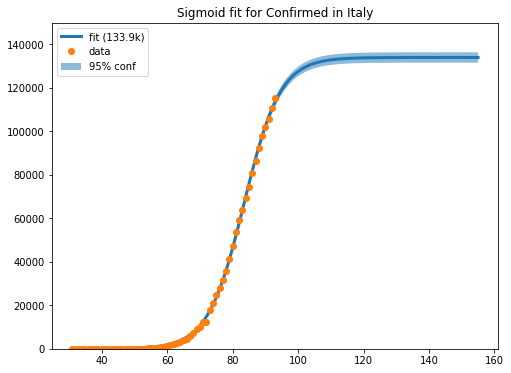

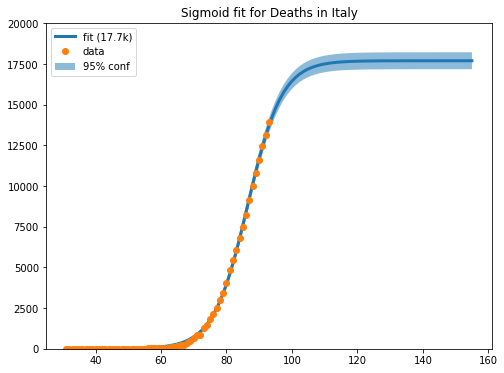

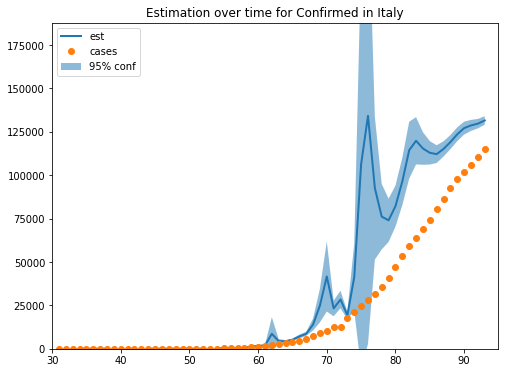

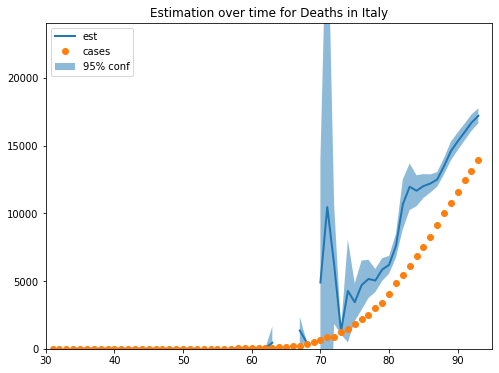

In [68]:
allPlots('Italy')

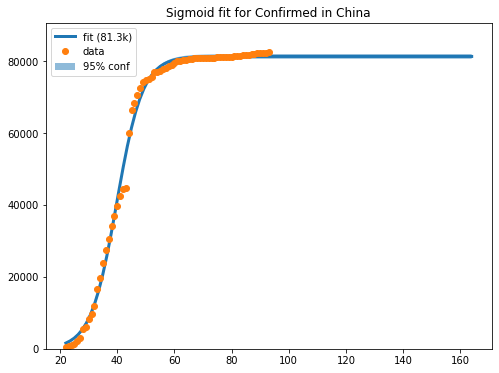

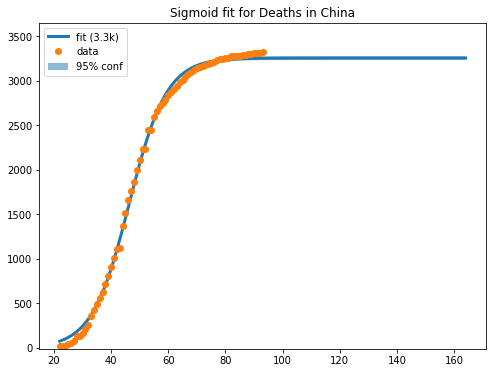

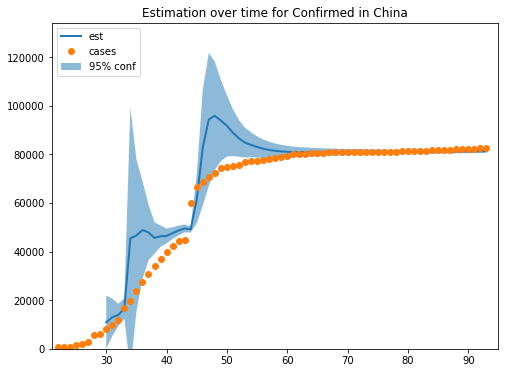

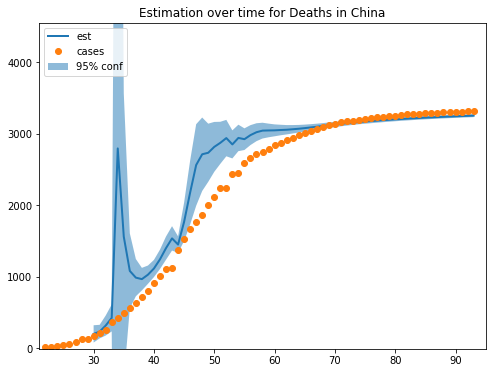

In [69]:
allPlots('China')

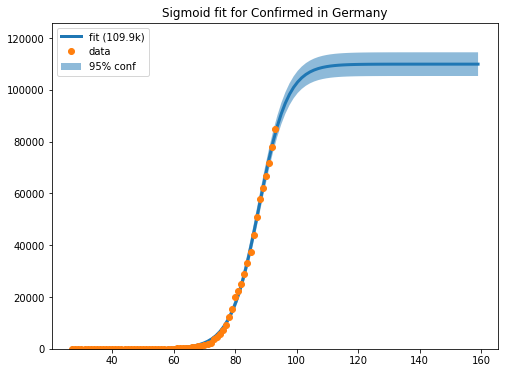

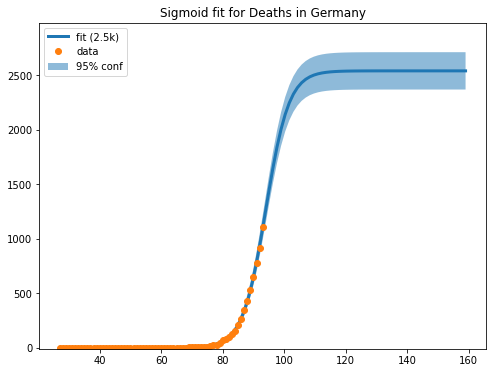

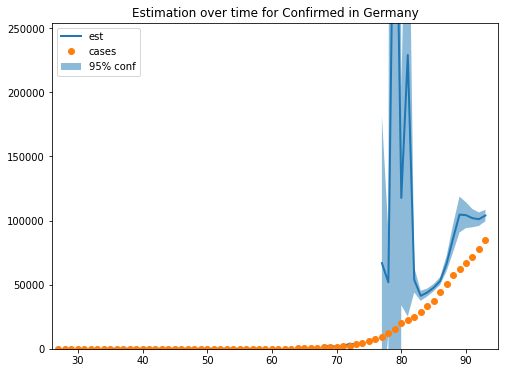

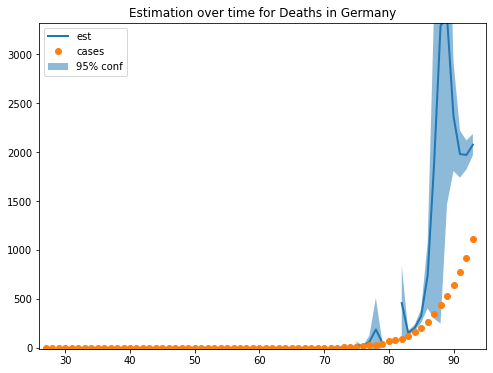

In [70]:
allPlots('Germany')

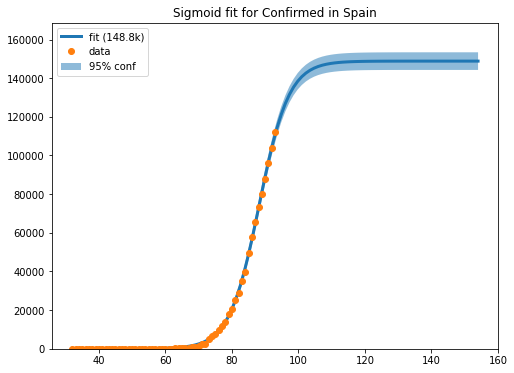

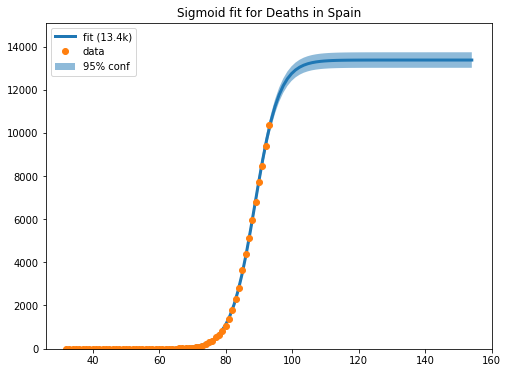

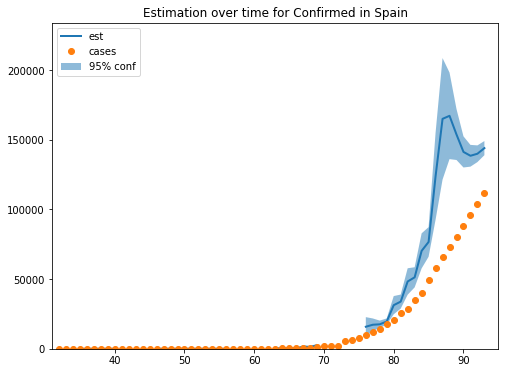

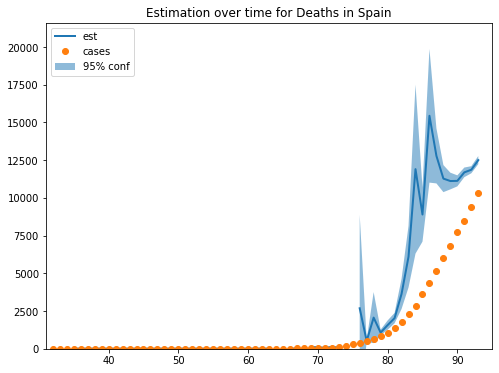

In [71]:
allPlots('Spain')

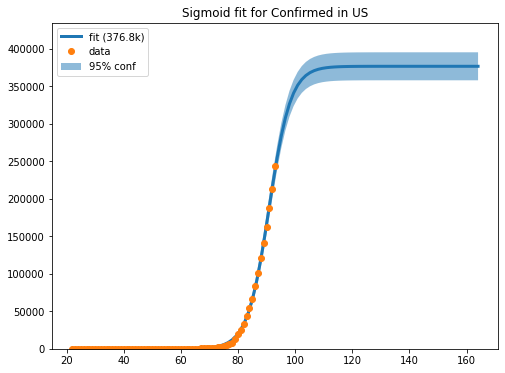

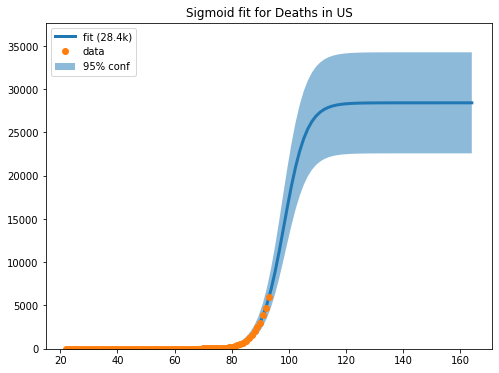

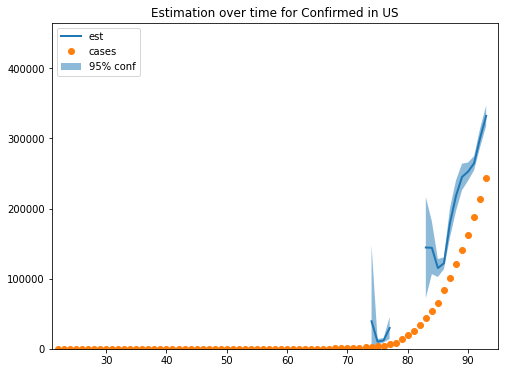

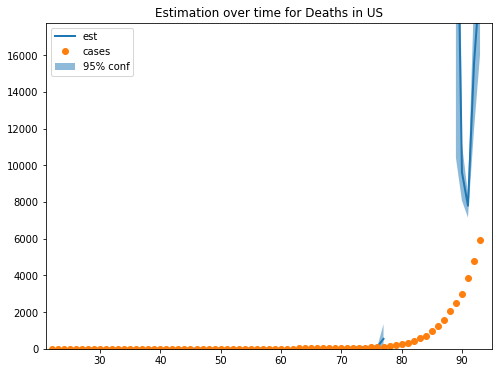

In [72]:
allPlots('US')

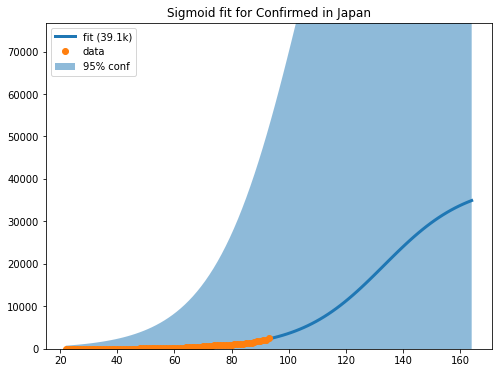

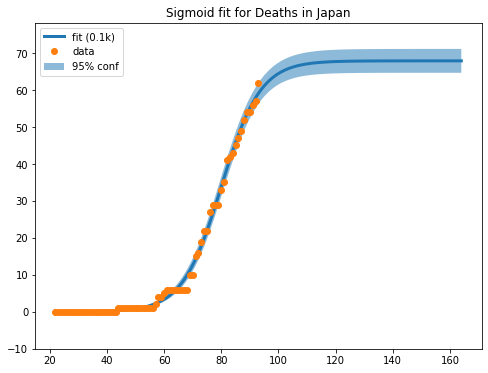

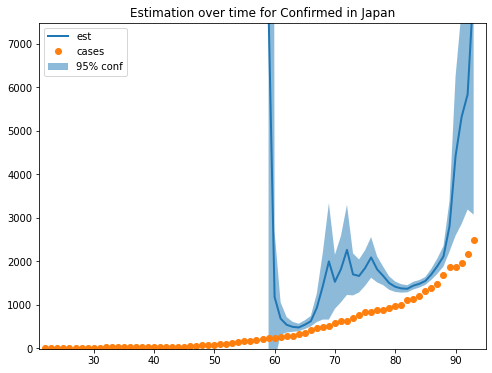

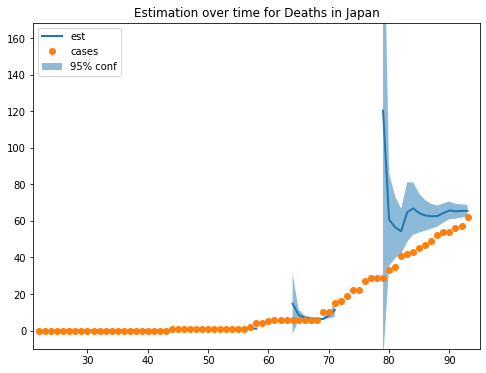

In [73]:
allPlots('Japan')

In [74]:
regions = ts['Country/Region'].unique()
regions

array(['China', 'Japan', 'Korea, South', 'Taiwan*', 'Thailand', 'US',
       'Vietnam', 'Singapore', 'France', 'Malaysia', 'Nepal', 'Canada',
       'Australia', 'Sri Lanka', 'Germany', 'Cambodia',
       'United Arab Emirates', 'Finland', 'Philippines', 'India',
       'Sweden', 'United Kingdom', 'Russia', 'Italy', 'Spain', 'Belgium',
       'Diamond Princess', 'Egypt', 'Iran', 'Lebanon', 'Israel', 'Oman',
       'Kuwait', 'Afghanistan', 'Bahrain', 'Iraq', 'Switzerland',
       'Algeria', 'Austria', 'Croatia', 'Pakistan', 'Norway', 'Romania',
       'North Macedonia', 'Georgia', 'Brazil', 'Greece', 'Netherlands',
       'San Marino', 'Denmark', 'Estonia', 'Nigeria', 'Mexico',
       'Lithuania', 'New Zealand', 'Belarus', 'Iceland', 'Monaco',
       'Luxembourg', 'Qatar', 'Ireland', 'Czechia', 'Armenia',
       'Azerbaijan', 'Dominican Republic', 'Ecuador', 'Morocco',
       'Portugal', 'Latvia', 'Senegal', 'Saudi Arabia', 'Andorra',
       'Indonesia', 'Ukraine', 'Chile', 'Argentina',

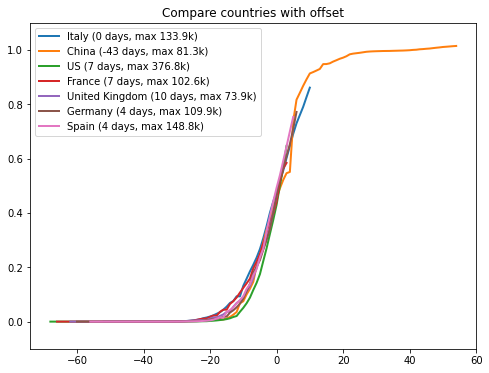

In [75]:
plotRegions(['Italy','China','US','France','United Kingdom','Germany','Spain'])

Error during fit for World: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


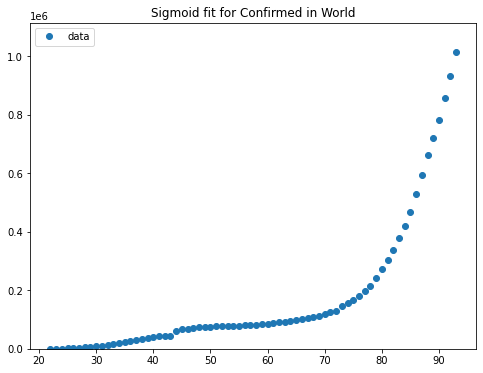

Error during fit for World: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


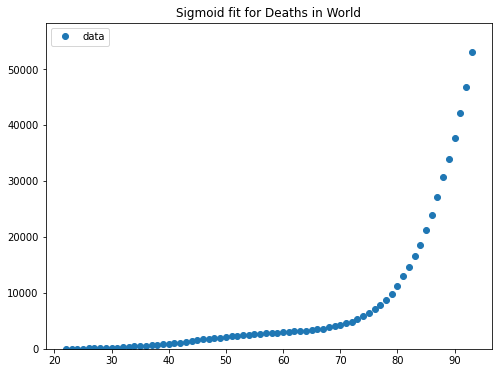

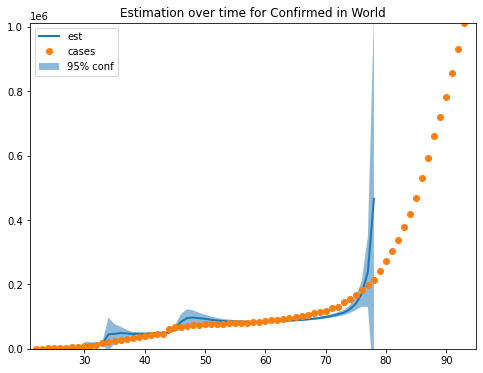

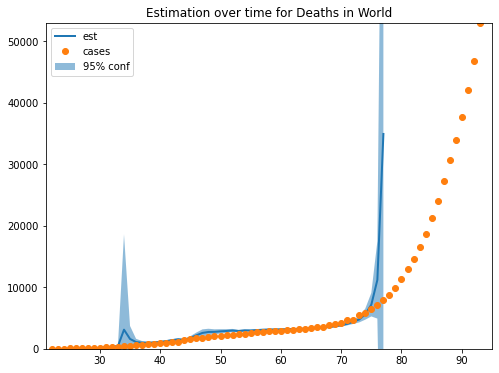

In [76]:
allPlots(None,'World')

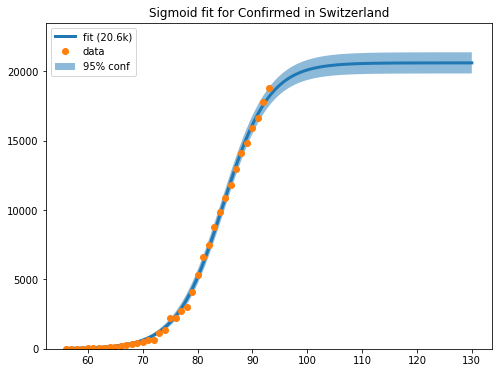

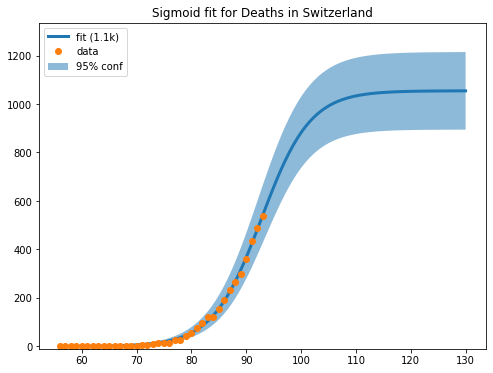

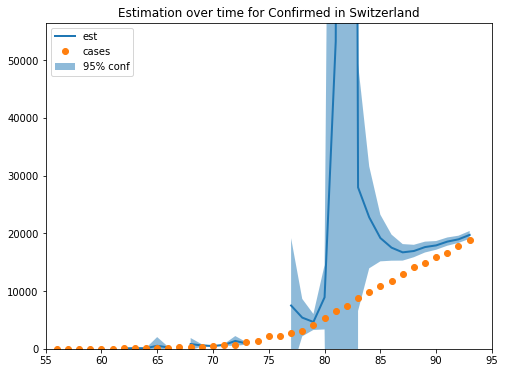

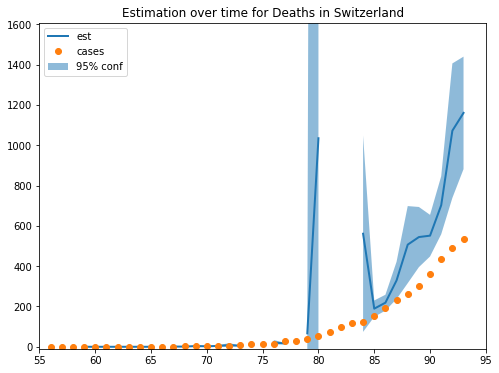

In [77]:
allPlots('Switzerland')

In [78]:
def x2date(x):
    try:
        res = base+np.timedelta64(int(x),'D')
    except:
        res = np.NaN
    return res

def forecastTol(region, tolerance=0.99, metric='Confirmed'):
    pcov, perr = estimate(region, metric)

    x0, L, k = pcov
    x0m, Lm, km = (pcov-perr*2)
    x0M, LM, kM = (pcov+perr*2)

    x =  logit(tolerance) / k + x0
    xm = logit(tolerance) / kM + x0m
    xM = logit(tolerance) / km + x0M

    #print (xm, xM)
    #print("%.1f%% of %-9s in %-22s: " % (tolerance*100, metric, region), base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))
    return {'Region': region,\
            'Metric':  "%.1f%% of %-9s" % (tolerance*100, metric),\
            'From': x2date(xm),\
            'Est': x2date(x),\
            'To': x2date(xM)}
    
def forecastCases(region, leftcases=1, metric='Confirmed'):
    pcov, perr = estimate(region, metric)

    x0, L, k = pcov
    x0m, Lm, km = (pcov-perr*2)
    x0M, LM, kM = (pcov+perr*2)

    x = logit((L-leftcases)/L) / k + x0
    xm = logit((Lm-leftcases)/Lm) / kM + x0m
    xM = logit((LM-leftcases)/LM) / km + x0M

    #print (xm, xM)
    #print("%3d %-9s left in %-22s: " % (leftcases, metric, region), base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))
    return {'Region': region,\
            'Metric':  "%d %-9s left" % (leftcases, metric),\
            'From': x2date(xm),\
            'Est': x2date(x),\
            'To': x2date(xM)}


In [79]:
def allForecasts(region, tolerance=0.99, leftcases=1):
    data = []
    data.append(forecastTol(region, tolerance))
    data.append(forecastTol(region, tolerance,'Deaths'))
    data.append(forecastCases(region, leftcases))
    data.append(forecastCases(region, leftcases,'Deaths'))
    display(pd.DataFrame(data))

In [80]:
allForecasts('Italy')

,Region,Metric,From,Est,To
0,Italy,99.0% of Confirmed,2020-04-17,2020-04-17,2020-04-18
1,Italy,99.0% of Deaths,2020-04-18,2020-04-19,2020-04-20
2,Italy,1 Confirmed left,2020-05-25,2020-05-27,2020-05-29
3,Italy,1 Deaths left,2020-05-14,2020-05-16,2020-05-18


In [81]:
allForecasts('US')

,Region,Metric,From,Est,To
0,US,99.0% of Confirmed,2020-04-16,2020-04-17,2020-04-18
1,US,99.0% of Deaths,2020-04-23,2020-04-25,2020-04-26
2,US,1 Confirmed left,2020-05-16,2020-05-18,2020-05-20
3,US,1 Deaths left,2020-05-14,2020-05-17,2020-05-20


In [82]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

data = [forecastTol(r, 0.99) for r in regions]
display(pd.DataFrame(data).sort_values(by=['Est'],ascending=False))
print()


,Region,Metric,From,Est,To
164,Timor-Leste,99.0% of Confirmed,34401788-02-24,36271566-06-22,38356289-04-12
1,Japan,99.0% of Confirmed,2020-05-17,2020-07-18,2020-09-19
32,Kuwait,99.0% of Confirmed,2020-05-21,2020-06-19,2020-07-21
174,Kosovo,99.0% of Confirmed,2019-10-27,2020-06-02,2020-09-15
6,Vietnam,99.0% of Confirmed,2020-05-12,2020-05-27,2020-06-12
3,Taiwan*,99.0% of Confirmed,2020-05-03,2020-05-21,2020-06-10
107,Jamaica,99.0% of Confirmed,2020-04-22,2020-05-17,2020-06-20
28,Iran,99.0% of Confirmed,2020-05-06,2020-05-16,2020-05-27
35,Iraq,99.0% of Confirmed,2020-05-07,2020-05-15,2020-05-23
102,Cyprus,99.0% of Confirmed,2020-04-24,2020-05-14,2020-06-05


In [83]:
data = [forecastCases(r, 1) for r in regions]
display(pd.DataFrame(data).sort_values(by=['Est'],ascending=False))
print()

,Region,Metric,From,Est,To
164,Timor-Leste,1 Confirmed left,2020-10-29,2020-11-27,2020-12-29
1,Japan,1 Confirmed left,NaT,2020-10-13,2021-01-17
32,Kuwait,1 Confirmed left,2020-04-06,2020-07-24,2020-09-12
28,Iran,1 Confirmed left,2020-06-29,2020-07-20,2020-08-11
174,Kosovo,1 Confirmed left,NaT,2020-06-19,2020-08-18
20,Sweden,1 Confirmed left,2020-06-05,2020-06-18,2020-07-01
6,Vietnam,1 Confirmed left,2020-05-23,2020-06-17,2020-07-11
3,Taiwan*,1 Confirmed left,2020-05-14,2020-06-11,2020-07-12
35,Iraq,1 Confirmed left,2020-05-27,2020-06-10,2020-06-24
102,Cyprus,1 Confirmed left,NaT,2020-06-03,2020-07-08
